# Latent Variable Models : applications and examples

In [90]:
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

## Reminder & warm-up

An EM algorithm is an iterative optimization of the following variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT$.

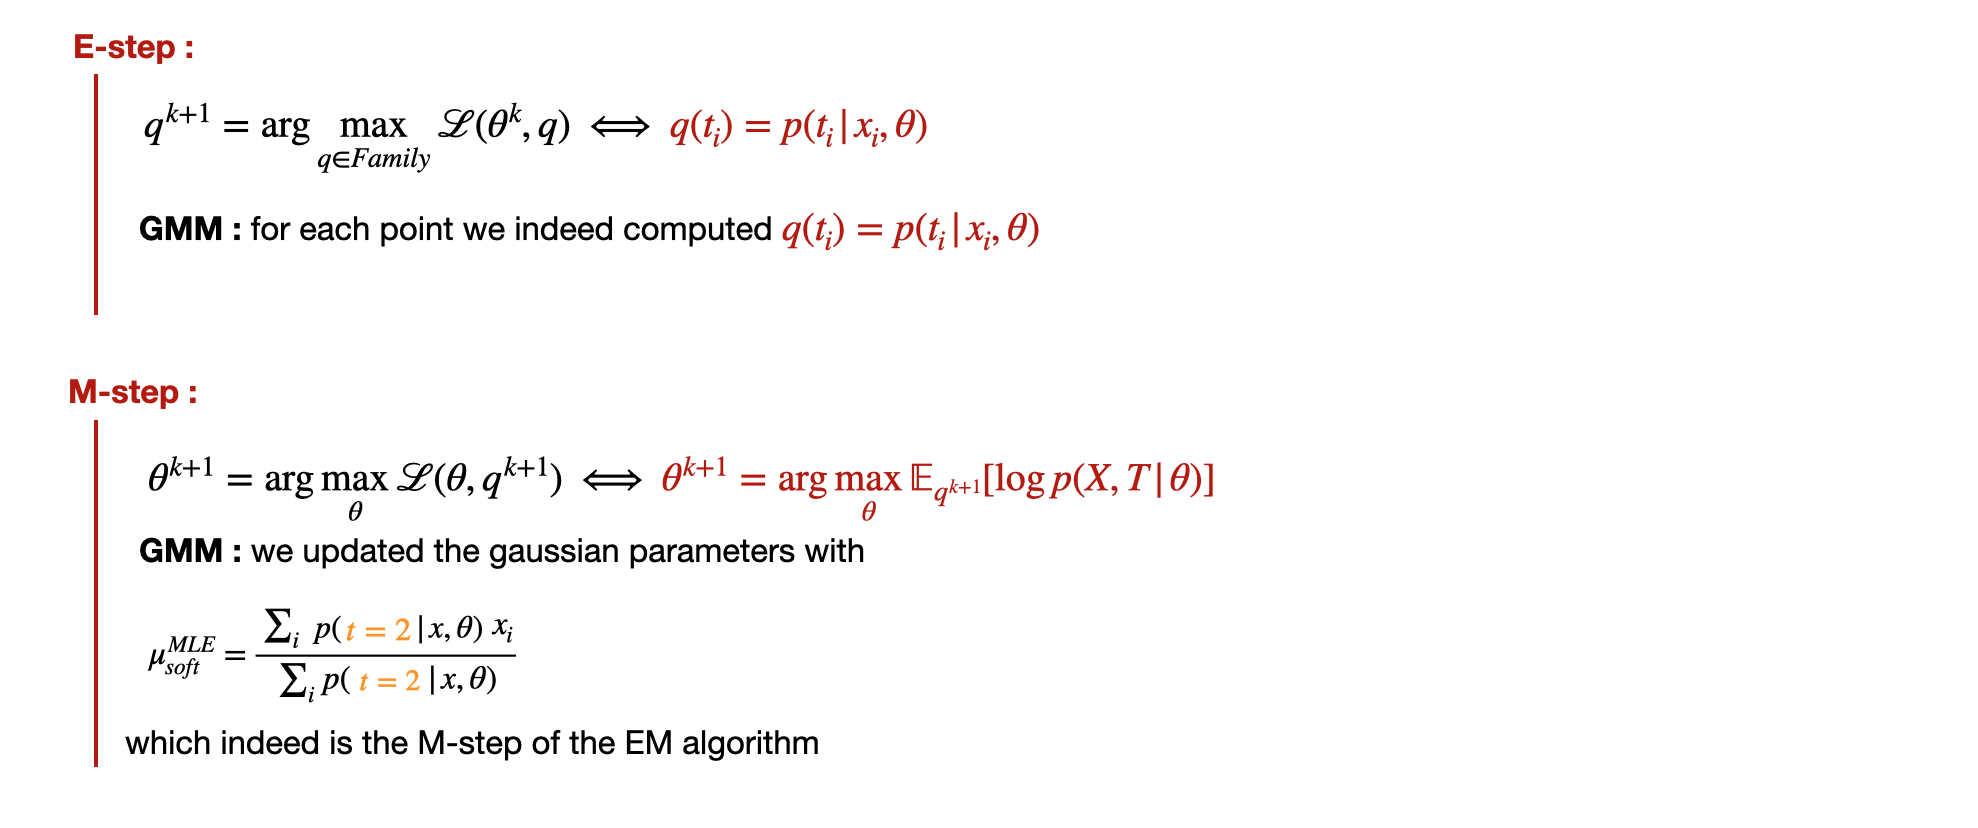

In [91]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data["data"]
y = data["target"]


**Question 1 :** Give the shape of X and y.

In [92]:
X.shape, y.shape

((569, 30), (569,))

**Question 2 :** Plot the first two dimension of X and color the instances according to its class y

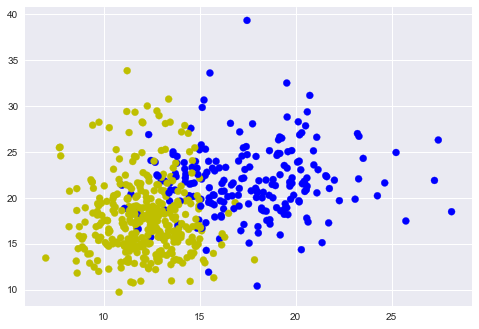

In [93]:
import  matplotlib.pyplot as plt
import numpy as np

colors = np.array(["b"]*len(y))
colors[y==1] = "y"

plt.scatter(X[:,0], X[:,1], c=colors)



For the sake of the following section, let us discard completely the class y.

## 1. Clustering : a probabilistic point of view with k-means

We recall that k-means is a clustering algorithm which has the following pseudo-algorotihm :

**Input :** number of clusters $K$, dataset $X$

**Output :** the clusters

1. Randomly initialize the parameters $\theta = \{centroid_1, \dots, centroid_K\}$

2. Repeat until convergence :
    - For each instance $x$, compute the closest centroid :
    $$
    k_i = \arg\min_{k} \lVert x_i - centroid_k \lVert^2
    $$
    
    - Update the centroids :
    $$
    centroid_k = \frac{\sum_{i:k_i=k} x_i}{|{i:k_i=k}|}
    $$

**Question 3 :** Define the function `kmeans_naive` and test it out on $X$ with $K=3$. Plot the first two dimensions of $X$ and color the instances according to its cluster

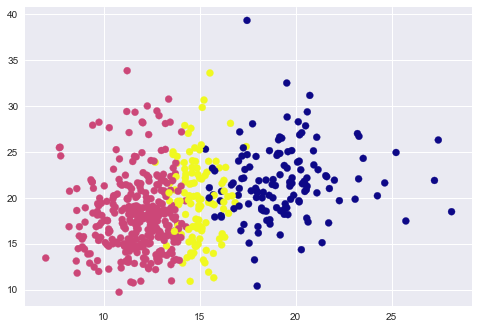

In [94]:
from sklearn.metrics import pairwise_distances
import numpy as np
# you can use "pairwise_distances" for computing the closest centroid between X and the centroids
 
def kmeans_naive(K, X, max_iter = 10):
    ### CODE

    # step 1 : let's init theta randomly
    rand_indices = np.random.choice(X.shape[0], size = K)
    centroids = X[rand_indices]

    # step 2 : repeat until convergence
    for _ in range(max_iter):
        cluster_distance = pairwise_distances(X, centroids, metric = 'euclidean', force_all_finite = False)
        cluster_assignment = np.argmin(cluster_distance, axis = 1)

    for k in range(K):
        centroids[k,:] = np.nanmean(X[cluster_assignment == k], axis = 0)

    return cluster_assignment


labels =kmeans_naive(3,X,5)
plt.scatter(X[:,0], X[:,1], c=labels,cmap=plt.get_cmap("plasma"))

**Question 4 :** Define the function `GMM_hard` (p.24) which fit a Gaussian Mixture Model (with hard clustering). We assume two things here 
- $\Sigma = I_d$ is **known** and is identical ;
- $\pi_k$ is known and is uniform.

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

eps=1e-8 

def PDF(data, means, variances):
    return 1/(np.sqrt(2 * np.pi * variances) + eps) * np.exp(-1/2 * (np.square(data - means) / (variances + eps)))

def GMM_hard(data, k=3, max_iter=100):
    weights = np.ones((k, 1)) / k # shape=(k, 1)

    means = np.random.choice(data, k)[:, np.newaxis] # shape=(k, 1)
    
    variances = np.random.random_sample(size=k)[:, np.newaxis] # shape=(k, 1)

    data = np.repeat(data[np.newaxis, :], k, 0) # shape=(k, n)

    for step in range(max_iter):
        # Expectation step
        likelihood = PDF(data, means, np.sqrt(variances)) # shape=(k, n)

        # Maximization step
        b = likelihood * weights # shape=(k, n)
        b /= np.sum(b, axis=1)[:, np.newaxis] + eps

        # updage means, variances, and weights
        means = np.sum(b * data, axis=1)[:, np.newaxis] / (np.sum(b, axis=1)[:, np.newaxis] + eps)
        variances = np.sum(b * np.square(data - means), axis=1)[:, np.newaxis] / (np.sum(b, axis=1)[:, np.newaxis] + eps)
        weights = np.mean(b, axis=1)[:, np.newaxis]
        
    return means, variances

In [96]:
np.random.seed(42)
gmm = GMM_hard(X[1],k=3, max_iter=100)
gmm

(array([[0.11544744],
        [0.11544744],
        [0.11544744]]),
 array([[0.01645313],
        [0.01645313],
        [0.01645313]]))

**Question 5 :** What do we see ?

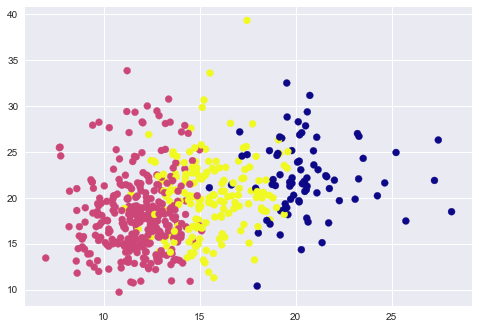

In [97]:
from sklearn.mixture import GaussianMixture
gmm_s = GaussianMixture(n_components = 3, max_iter = 100, covariance_type = 'full')
gmm_s.fit(X)
labels=gmm_s.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels,cmap=plt.get_cmap("plasma"))

**Question 5 :** Redefine `GMM_hard` and let us take assume that $\Sigma_k$ and $\pi_k$ are no longer known. Plot the results

**[OPTIONAL] Question 6 :** Define `GMM_soft` which fit a GMM with soft clustering. Plot the results

## 2. Dimensionality reduction : a probabilistic point of view with PCA

PPCA is a dimensionality reduction technique that is often used when we have some missing values in the dataset. We assume that each latent variable is normally distributed :
$$
t_i \sim \mathcal{N}(0, I_K)
$$

The instance $x$ associated is generated by the following projection :
$$
x_i | t_i \sim \mathcal{N}(W\cdot t_i + b, \Sigma)
$$

**Question 7 :** The PPCA is a general form of PCA. Indeed, we can observe it in marginalizing the latent variable. Find out the distribution of each instance $x | \theta$ (you can use the wikipedia table for the normal conjugacy).

**Question 8 :** Compute the E-step of the PPCA

**Question 9 :** Compute the M-step of the PPCA

**Question 10 :** Do a reduction of dimensionality with PPCA and plot the results with its true labels on a 2D graph

### A quick look on the dimensionality reduction with PCA and t-SNE

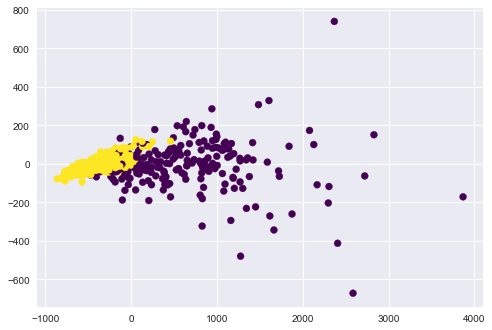

In [98]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c = y, cmap='viridis');

/Users/ibrahim/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ibrahim/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


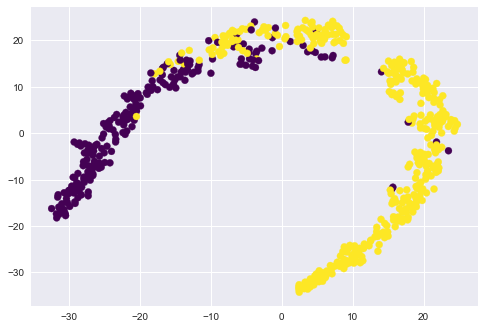

In [99]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_embedded = tsne.fit_transform(X)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y, cmap='viridis');